In [ ]:
!pip install -q efficientnet kagglehub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import cv2
import os
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import efficientnet.tfkeras as efn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
path = kagglehub.dataset_download("harunshimanto/epileptic-seizure-recognition")
csv_path = os.path.join(path, "Epileptic Seizure Recognition.csv")
df = pd.read_csv(csv_path)
df.drop(columns=[df.columns[0]], inplace=True)
df = df.drop(columns=['Unnamed'], errors='ignore')
df = df[df.iloc[:, 1:179].sum(axis=1) != 0]

X = df.iloc[:, 1:179].values
y = df.iloc[:, -1].values - 1

In [ ]:
def signal_to_stft_image(signal, sr=178):
    signal = np.asarray(signal, dtype=np.float32)
    stft = librosa.stft(signal, n_fft=64)
    stft_db = librosa.amplitude_to_db(np.abs(stft))
    stft_db_resized = cv2.resize(stft_db, (128, 128))
    return stft_db_resized

X_images = np.array([signal_to_stft_image(x) for x in X])
X_images = np.expand_dims(X_images, axis=-1)
X_images = np.repeat(X_images, 3, axis=-1)
X_images = X_images / 255.0


X_train, X_test, y_train, y_test = train_test_split(
    X_images, y, test_size=0.3, stratify=y, random_state=42
)


class_weights = dict(enumerate(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)))


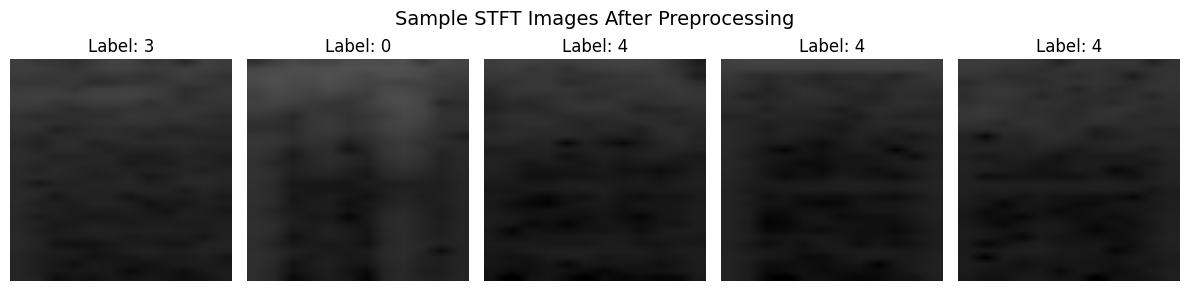

In [ ]:
import matplotlib.pyplot as plt

# عرض أول 5 صور STFT بعد التحويل
plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_images[i].squeeze(), cmap='magma')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')

plt.suptitle("Sample STFT Images After Preprocessing", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
base_model = efn.EfficientNetB0(include_top=False, input_shape=(128, 128, 3), weights=None)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, verbose=1)
]


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 727s 3s/step - accuracy: 0.5087 - loss: 1.0969 - val_accuracy: 0.2161 - val_loss: 4.3254 - learning_rate: 0.0010
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 662s 3s/step - accuracy: 0.6986 - loss: 0.6222 - val_accuracy: 0.3714 - val_loss: 1.6661 - learning_rate: 0.0010
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 685s 3s/step - accuracy: 0.7367 - loss: 0.5406 - val_accuracy: 0.6994 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - accuracy: 0.7555 - loss: 0.4963 - val_accuracy: 0.7354 - val_loss: 0.5214 - learning_rate: 0.0010
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 726s 3s/step - accuracy: 0.7818 - loss: 0.4730 - val_accuracy: 0.7938 - val_loss: 0.4258 - learning_rate: 0.0010
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.7883 - loss: 0.4289 - val_accuracy: 0.7925 - val_loss: 0.4260 - learning_rate: 0.0010
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 685s 3s/step - accuracy: 0.8215 - loss: 0.

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", test_acc)


108/108 ━━━━━━━━━━━━━━━━━━━━ 62s 572ms/step - accuracy: 0.7951 - loss: 0.4349
Test Accuracy: 0.7904347777366638


108/108 ━━━━━━━━━━━━━━━━━━━━ 64s 588ms/step


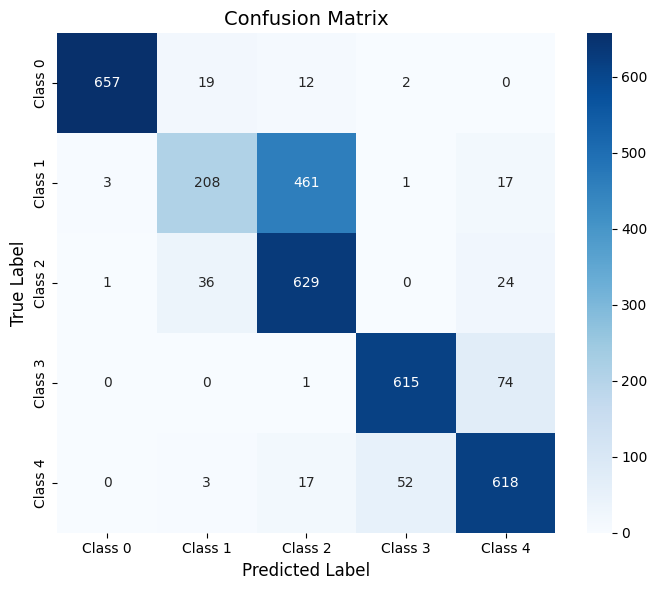


Classification Report:
              precision    recall  f1-score   support

           0     0.9939    0.9522    0.9726       690
           1     0.7820    0.3014    0.4351       690
           2     0.5616    0.9116    0.6950       690
           3     0.9179    0.8913    0.9044       690
           4     0.8431    0.8957    0.8686       690

    accuracy                         0.7904      3450
   macro avg     0.8197    0.7904    0.7752      3450
weighted avg     0.8197    0.7904    0.7752      3450

Raw Confusion Matrix:
[[657  19  12   2   0]
 [  3 208 461   1  17]
 [  1  36 629   0  24]
 [  0   0   1 615  74]
 [  0   3  17  52 618]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediction
y_pred = model.predict(X_test).argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = [f'Class {i}' for i in range(cm.shape[0])]

# Plotting the Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Raw Confusion Matrix Output
print("Raw Confusion Matrix:")
print(cm)


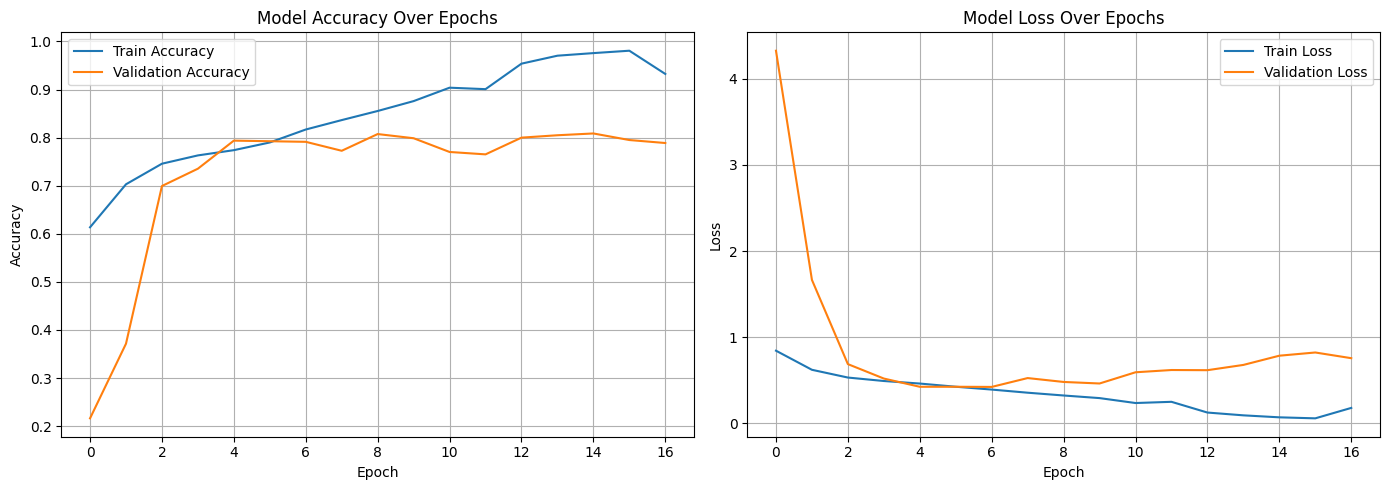

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # دقة النموذج
    plt.figure(figsize=(14, 5))

    # دقة التدريب والتقييم
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # الخسارة
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# بعد انتهاء التدريب
plot_learning_curves(history)
